# Demo - Probabilistic Fourier with AR model on coefficients

This file provides an demo of the probabilistic Fourier framework as outline in "Bayesian spectrum estimation of unevenly sampled data" - Qi et al.

$$ {\bf{s}}_t = {\bf{s}}_{t-1} + {\bf{w}}_t $$
$$ {\bf{y}}_t = C^\top {\bf{s}}_t + {\bf{v}}_t $$

## Load packages and functions

In [1]:
using ForneyLab       # based on last official release
using LinearAlgebra
using Plots
using PyPlot
using ProgressMeter
using Compat
using WAV
using Base64
using FileIO
using HDF5
using FLAC
using DSP
using FFTW
using LAR
using LAR.Node
#using LAR.AR
#using LAR.DataAR

include("../functions/auxiliary/buffer.jl")
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/workflow.jl")
include("../functions/auxiliary/fourier.jl")
;

## Settings

In [2]:
# data loading
sound_file1 = "../data/obama.wav"   # specify sound location
sound_file2 = "../data/drilling.wav"   # specify sound location
fs_desired = 8000                  # specify desired sampling frequency

# input buffer parameters
step_size = 1                      # specify step size of buffer
buffer_size = 32                    # specify size of buffer

# probabilistic fourier parameters 
var_observation = 1e-3               # specify observation noise var
freq_bins = 5
freq = collect(fs_desired/(2*(freq_bins+1)):fs_desired/(2*(freq_bins+1)):(fs_desired/2-fs_desired/(2*(freq_bins+1))))

# AR modelling
AR_order = 5
iterations = 3

# load model parameters
load_file1 = "../inferred_values/all_speech_AR05_10freqs.h5" # file in which model parameters are present
load_file2 = "../inferred_values/all_drilling_AR05_10freqs.h5" # file in which model parameters are present
;

## Load data

In [3]:
# load and process speech signal
x_time1, fs_time1 = wavread(sound_file1, format="native")
fs_time1 = Int(fs_time1)
x_time1 = x_time1[24*fs_time1+1:27*fs_time1]
x_time1 = resample(x_time1, fs_desired/fs_time1)
x_time1 = 100*x_time1/var(x_time1)

# load and process speech signal
x_time2, fs_time2 = wavread(sound_file2, format="native")
fs_time2 = Int(fs_time2)
x_time2 = x_time2[24*fs_time2+1:27*fs_time2]
x_time2 = resample(x_time2, fs_desired/fs_time2)
x_time2 = 100*x_time2/var(x_time2)

x_tot = x_time1 + x_time2

# specify time axis
t = collect((1:length(x_time1))/fs_desired)

# create audioplayer
audioplayers(x_time1, x_time2, x_tot, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

In [4]:
# placeholder for parameters
params1 = Array{Dict{String, Union{Array{Float64}, Float64}}, 1}(undef, 2*freq_bins)
params2 = Array{Dict{String, Union{Array{Float64}, Float64}}, 1}(undef, 2*freq_bins)

# load parameters
for k = 1:2*freq_bins
    # load parameters of imaginary coefficients
    params1[k] = h5read(load_file1, "bin_"*string(k, pad=2))     
    params2[k] = h5read(load_file2, "bin_"*string(k, pad=2))     
end
;

## Visualize data

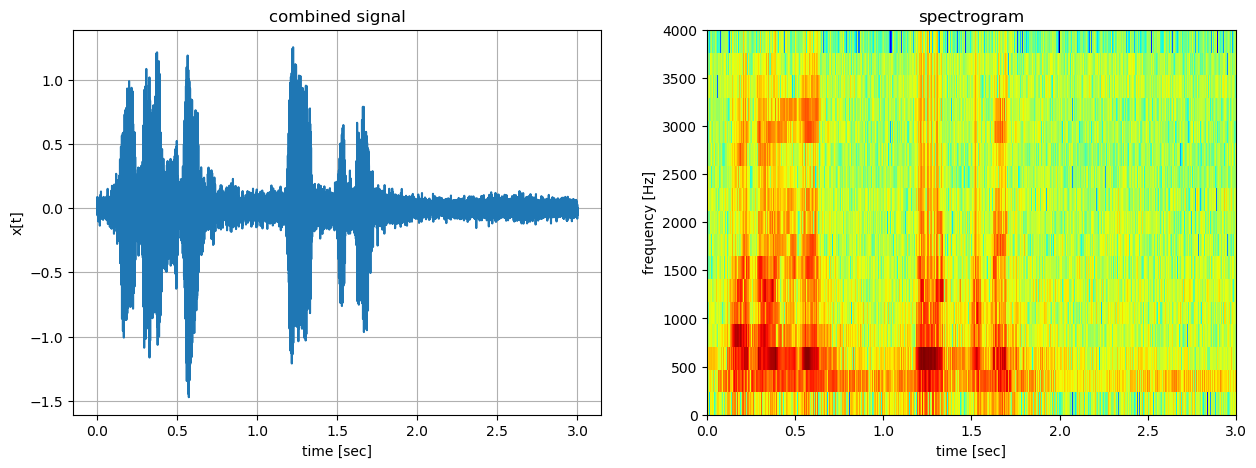

In [5]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t, x_tot)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_tot, 32, 0, fs=fs_desired), fs_desired, ax=ax[2])

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("combined signal"), ax[2].set_title("spectrogram")
;

## Specify generative model

In [10]:
# create factor graph
fg = FactorGraph()

# placeholders
z_min1 = Array{Variable,1}(undef, 2*length(freq))
Œ≥1 = Array{Variable,1}(undef, 2*length(freq))
Œ∏1 = Array{Variable,1}(undef, 2*length(freq))
z1 = Array{Variable,1}(undef, 2*length(freq))

# placeholders
z_min2 = Array{Variable,1}(undef, 2*length(freq))
Œ≥2 = Array{Variable,1}(undef, 2*length(freq))
Œ∏2 = Array{Variable,1}(undef, 2*length(freq))
z2 = Array{Variable,1}(undef, 2*length(freq))

# specify observation noise
@RV v ~ GaussianMeanVariance(zeros(buffer_size), var_observation*Ic(buffer_size))

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min1,k)] z_min1[k] ~ GaussianMeanVariance(placeholder(pad(:Œº_z_min1, k), dims = (AR_order,)),
                                        placeholder(pad(:Œ£_z_min1, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:Œ≥1,k)] Œ≥1[k] ~ ForneyLab.Gamma(placeholder(pad(:a_Œ≥1,k)), placeholder(pad(:b_Œ≥1,k)))
    @RV [id=pad(:Œ∏1,k)] Œ∏1[k] ~ GaussianMeanVariance(placeholder(pad(:Œº_Œ∏1,k), dims=(AR_order,)), placeholder(pad(:Œ£_Œ∏1,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z1,k)] z1[k] ~ LAR.Autoregressive(Œ∏1[k], z_min1[k], Œ≥1[k])
end

# specify previous hidden state (spectral component buffer)
for k = 1:2*length(freq)
    @RV [id=pad(:z_min2,k)] z_min2[k] ~ GaussianMeanVariance(placeholder(pad(:Œº_z_min2, k), dims = (AR_order,)),
                                        placeholder(pad(:Œ£_z_min2, k), dims = (AR_order, AR_order)))
    @RV [id=pad(:Œ≥2,k)] Œ≥2[k] ~ ForneyLab.Gamma(placeholder(pad(:a_Œ≥2,k)), placeholder(pad(:b_Œ≥2,k)))
    @RV [id=pad(:Œ∏2,k)] Œ∏2[k] ~ GaussianMeanVariance(placeholder(pad(:Œº_Œ∏2,k), dims=(AR_order,)), placeholder(pad(:Œ£_Œ∏2,k), dims=(AR_order, AR_order)))
    @RV [id=pad(:z2,k)] z2[k] ~ LAR.Autoregressive(Œ∏2[k], z_min2[k], Œ≥2[k])
end

# specify Fourier matrix
Ceme11 = Array{Variable,1}(undef, 2*length(freq))
Ceme12 = Array{Variable,1}(undef, 2*length(freq))
for k=1:2*length(freq)
    @RV Ceme11[k] 
    placeholder(Ceme11[k], pad(:Ceme11,k), dims = (buffer_size, AR_order))
    @RV Ceme12[k] 
    placeholder(Ceme12[k], pad(:Ceme12,k), dims = (buffer_size, AR_order))
end

# specify observations
@RV x1 = sum(Ceme11.*z1)
@RV x2 = sum(Ceme12.*z2)
@RV y = x1 + x2 + v

# create placeholder for observations
placeholder(y, :y, dims = (buffer_size,))

# draw factor graph
ForneyLab.draw(fg)
ForneyLab.draw(fg, external_viewer=:default)
;

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.38.0 (20140413.2041)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 760245272718350889 -->
 760245272718350889 
 
 ùí© 
 gaussianmeanvariance_14 
 
<!-- 4610134333103506268 -->
 4610134333103506268 
 
 placeholder_Œ£_z_min1_07 
 
<!-- 760245272718350889--4610134333103506268 -->
 760245272718350889--4610134333103506268 
 
 Œ£_z_min1_07 
 1 out 
 3 v 
 
<!-- 13387378090113867721 -->
 13387378090113867721 
 
 placeholder_Œº_z_min1_07 
 
<!-- 760245272718350889--13387378090113867721 -->
 760245272718350889--13387378090113867721 
 
 Œº_z_min1_07 
 1 out 
 2 m 
 
<!-- 9855271499746105144 -->
 9855271499746105144 
 
 placeholder_b_Œ≥2_02 
 
<!-- 8093353513974088887 -->
 8093353513974088887 
 
 Gam 
 gamma_5 
 
<!-- 6351942571162342066 -->
 6351942571162342066 
 
 placeholder_b_Œ≥1_05 
 
<!-- 8093353513974088887--6351942571162342066 -->
 8093353513974088887--6351942571162342066 
 
 b_Œ≥1_05 
 1 out 
 3 b 
 
<!-- 11053414775727722628 -->
 11053414775727722628 
 
 placeholder_a_Œ≥1_05 
 
<!-- 8093353513974088887--11053414775727722628 -->
 8093353513974088887--11053414775727722628 
 
 a_Œ≥1_05 
 1 out 
 2 a 
 
<!-- 9800293264039703728 -->
 9800293264039703728 
 
 placeholder_a_Œ≥2_06 
 
<!-- 12525712368421375964 -->
 12525712368421375964 
 
 ùí© 
 gaussianmeanvariance_2 
 
<!-- 6213554960298662961 -->
 6213554960298662961 
 
 placeholder_Œ£_z_min1_01 
 
<!-- 12525712368421375964--6213554960298662961 -->
 12525712368421375964--6213554960298662961 
 
 Œ£_z_min1_01 
 1 out 
 3 v 
 
<!-- 5686133497942776936 -->
 5686133497942776936 
 
 placeholder_Œº_z_min1_01 
 
<!-- 12525712368421375964--5686133497942776936 -->
 12525712368421375964--5686133497942776936 
 
 Œº_z_min1_01 
 1 out 
 2 m 
 
<!-- 5557745575937737743 -->
 5557745575937737743 
 
 placeholder_Œº_Œ∏1_06 
 
<!-- 12234183848104169910 -->
 12234183848104169910 
 
 placeholder_Œº_Œ∏1_03 
 
<!-- 5335690168106141396 -->
 5335690168106141396 
 
 ùí© 
 gaussianmeanvariance_21 
 
<!-- 7423643008442430839 -->
 7423643008442430839 
 
 placeholder_Œ£_Œ∏1_10 
 
<!-- 5335690168106141396--7423643008442430839 -->
 5335690168106141396--7423643008442430839 
 
 Œ£_Œ∏1_10 
 1 out 
 3 v 
 
<!-- 15955318621460441294 -->
 15955318621460441294 
 
 placeholder_Œº_Œ∏1_10 
 
<!-- 5335690168106141396--15955318621460441294 -->
 5335690168106141396--15955318621460441294 
 
 Œº_Œ∏1_10 
 1 out 
 2 m 
 
<!-- 11788145878537108515 -->
 11788145878537108515 
 
 placeholder_Œ£_Œ∏1_04 
 
<!-- 4191604344884945519 -->
 4191604344884945519 
 
 placeholder_Œº_z_min1_05 
 
<!-- 18183907631874081305 -->
 18183907631874081305 
 
 placeholder_Œ£_z_min2_08 
 
<!-- 16026183404574861034 -->
 16026183404574861034 
 
 √ó 
 multiplication_14 
 
<!-- 16371956730209981136 -->
 16371956730209981136 
 
 AR 
 autoregressive_14 
 
<!-- 16026183404574861034--16371956730209981136 -->
 16026183404574861034--16371956730209981136 
 
 z2_04 
 1 y 
 2 in1 
 
<!-- 13735595224444021504 -->
 13735595224444021504 
 
 placeholder_Ceme12_4 
 
<!-- 16026183404574861034--13735595224444021504 -->
 16026183404574861034--13735595224444021504 
 
 Ceme12_4 
 1 out 
 3 a 
 
<!-- 4864605422404172611 -->
 4864605422404172611 
 
 ùí© 
 gaussianmeanvariance_27 
 
<!-- 11680164263129516897 -->
 11680164263129516897 
 
 placeholder_Œº_Œ∏2_03 
 
<!-- 4864605422404172611--11680164263129516897 -->
 4864605422404172611--11680164263129516897 
 
 Œº_Œ∏2_03 
 1 out 
 2 m 
 
<!-- 1155489756435300508 -->
 1155489756435300508 
 
 placeholder_Œ£_Œ∏2_03 
 
<!-- 4864605422404172611--1155489756435300508 -->
 4864605422404172611--1155489756435300508 
 
 Œ£_Œ∏2_03 
 1 o

In [11]:
# specify recognition factorization and create algorithm
q = RecognitionFactorization(Œ∏1, z1, z_min1, Œ≥1, Œ∏2, z2, z_min2, Œ≥2, x1, x2, ids=[:Œ∏1 :z1 :z_min1 :Œ≥1 :Œ∏2 :z2 :z_min2 :Œ≥2 :x1 :x2])
algo = compatibility_fix(variationalAlgorithm(q))
# algo_F = freeEnergyAlgorithm(q) # throws error because the variables z are all connected

# evaluate algorithm
eval(Meta.parse(algo))
;

In [12]:
println(algo)

begin

function stepz_min2!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=Array{Message}(undef, 20))

messages[1] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:Œº_z_min2_10]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Œ£_z_min2_10]))
messages[2] = ruleVariationalARIn1PNPP(marginals[:z2_10], nothing, marginals[:Œ∏2_10], marginals[:Œ≥2_10])
messages[3] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:Œº_z_min2_09]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Œ£_z_min2_09]))
messages[4] = ruleVariationalARIn1PNPP(marginals[:z2_09], nothing, marginals[:Œ∏2_09], marginals[:Œ≥2_09])
messages[5] = ruleVBGaussianMeanVarianceOut(nothing, ProbabilityDistribution(ForneyLab.Multivariate, PointMass, m=data[:Œº_z_min2_08]), ProbabilityDistribution(MatrixVariate, PointMass, m=data[:Œ£_z_min2_08]))
messages[6] = ruleVariationalARIn1PNPP

## Perform inference

In [13]:
messages=Array{Message}(undef, 180)
data = Dict()
marginals = Dict()

# create placeholders for priors
Œº_z_min1 = Array{Array{Float64,1},1}(undef, 2*length(freq))
Œ£_z_min1 = Array{Array{Float64,2},1}(undef, 2*length(freq))
Œº_z_min2 = Array{Array{Float64,1},1}(undef, 2*length(freq))
Œ£_z_min2 = Array{Array{Float64,2},1}(undef, 2*length(freq))

# set priors 
for k = 1:2*length(freq)
    Œº_z_min1[k] = zeros(AR_order)
    Œ£_z_min1[k] = 1e-2*Ic(AR_order)    
    Œº_z_min2[k] = zeros(AR_order)
    Œ£_z_min2[k] = 1e-2*Ic(AR_order)
end

# create marginals
for k = 1:2*length(freq)
    marginals[pad(:Œ≥1, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=params1[k]["a_gamma"], b=params1[k]["b_gamma"])
    marginals[pad(:Œ∏1, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=params1[k]["mean_theta"], v=params1[k]["cov_theta"])
    marginals[pad(:z_min1, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=Œº_z_min1[k], v=Œ£_z_min1[k])
    marginals[pad(:Œ≥2, k)] = ProbabilityDistribution(ForneyLab.Univariate, ForneyLab.Gamma, a=params2[k]["a_gamma"], b=params2[k]["b_gamma"])
    marginals[pad(:Œ∏2, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=params2[k]["mean_theta"], v=params2[k]["cov_theta"])
    marginals[pad(:z_min2, k)] = ProbabilityDistribution(ForneyLab.Multivariate, GaussianMeanVariance, m=Œº_z_min2[k], v=Œ£_z_min2[k])
end

# initialize buffer
buf = BufferData(x_tot, t, buffer_size)

# initialize placeholder for hidden states and observation
Œº_x1 = Array{Array{Float64,1},1}(undef, len(buf, step_size))
Œ£_x1 = Array{Array{Float64,2},1}(undef, len(buf, step_size))
Œº_x2 = Array{Array{Float64,1},1}(undef, len(buf, step_size))
Œ£_x2 = Array{Array{Float64,2},1}(undef, len(buf, step_size))

# create progress bar
p = Progress(len(buf, step_size), 1, "Observed ")

# loop through samples
for k = 1:len(buf, step_size)
        
    # update progress bar
    update!(p, k)
    
    # fill data dictionary
    data[:y] = buf.buffer_s
    for f = 1:2*length(freq)
        data[pad(:Ceme11,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
        data[pad(:Ceme12,f)] = calc_C(freq, buf.buffer_t)*em(2*length(freq), f)*(em(AR_order, 1)')
    end
    
    # infer parameters
    for it = 1:iterations
        
        # update data
        for f = 1:2*length(freq)
            data[pad(:a_Œ≥1, f)] = params1[f]["a_gamma"]
            data[pad(:b_Œ≥1, f)] = params1[f]["b_gamma"]
            data[pad(:Œº_Œ∏1, f)] = params1[f]["mean_theta"]
            data[pad(:Œ£_Œ∏1, f)] = params1[f]["cov_theta"]
            data[pad(:Œº_z_min1, f)] = Œº_z_min1[f]
            data[pad(:Œ£_z_min1, f)] = Œ£_z_min1[f]
           
            data[pad(:a_Œ≥2, f)] = params2[f]["a_gamma"]
            data[pad(:b_Œ≥2, f)] = params2[f]["b_gamma"]
            data[pad(:Œº_Œ∏2, f)] = params2[f]["mean_theta"]
            data[pad(:Œ£_Œ∏2, f)] = params2[f]["cov_theta"]
            data[pad(:Œº_z_min2, f)] = Œº_z_min2[f]
            data[pad(:Œ£_z_min2, f)] = Œ£_z_min2[f]
        end
        
        # perform steps 
        marginals = Base.invokelatest(stepx1!, data, marginals, messages)  
        marginals = Base.invokelatest(stepx2!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz1!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz2!, data, marginals, messages)  
        marginals = Base.invokelatest(stepz_min1!, data, marginals, messages)
        marginals = Base.invokelatest(stepz_min2!, data, marginals, messages)
        marginals = Base.invokelatest(stepŒ≥1!, data, marginals, messages)
        marginals = Base.invokelatest(stepŒ≥2!, data, marginals, messages)
        marginals = Base.invokelatest(stepŒ∏1!, data, marginals, messages)
        marginals = Base.invokelatest(stepŒ∏2!, data, marginals, messages)

        # update hidden states
        for f = 1:2*length(freq)
            Œº_z_min1[f] = ForneyLab.unsafeMean(marginals[pad(:z_min1,f)])
            Œ£_z_min1[f] = ForneyLab.unsafeCov(marginals[pad(:z_min1,f)])            
            Œº_z_min2[f] = ForneyLab.unsafeMean(marginals[pad(:z_min2,f)])
            Œ£_z_min2[f] = ForneyLab.unsafeCov(marginals[pad(:z_min2,f)])
        end
    end
        
    # update hidden states
    for f = 1:2*length(freq)
        Œº_z_min1[f] = ForneyLab.unsafeMean(marginals[pad(:z1,f)])
        Œ£_z_min1[f] = ForneyLab.unsafeCov(marginals[pad(:z1,f)])            
        Œº_z_min2[f] = ForneyLab.unsafeMean(marginals[pad(:z2,f)])
        Œ£_z_min2[f] = ForneyLab.unsafeCov(marginals[pad(:z2,f)])
    end
    
    # fetch predictions
    Œº_x1[k] = ForneyLab.unsafeMean(marginals[:x1])
    Œ£_x1[k] = ForneyLab.unsafeCov(marginals[:x1])
    Œº_x2[k] = ForneyLab.unsafeMean(marginals[:x2])
    Œ£_x2[k] = ForneyLab.unsafeCov(marginals[:x2])
    
    # update buffer
    FLAG_data_remaining = step!(buf, step_size)
    
end

Observed 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:22:135:18


In [14]:
# convert Œº_x to a 1d array
Œº_x_pred = expand(reverse(hcat(Œº_x...),dims=1))

# convert s_x to a 2d array
if length(size(Œº_s)) != 2
    Œº_s = hcat(Œº_s...)
end

# calculate magnitude spectrum
mag_Œº_s = log10.((Œº_s[1:length(freq),:].^2 + Œº_s[length(freq)+1:end,:].^2))


# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
cmp = ax[1].imshow(mag_Œº_s,
                   aspect="auto",
                   cmap="jet",
                   origin="lower",
                   extent=[minimum(t), maximum(t), 1, length(freq)])
fig.colorbar(cmp, ax=ax[1])

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(x_time, 2*length(freq)+1, 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# change visuals
ax[1].set_xlim(minimum(t), maximum(t)), ax[2].set_ylim(minimum(freq), maximum(freq)), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("frequency [Hz]"), ax[1].set_title("Predicted spectrum"), ax[2].set_title("STFT spectrum")
#cmp.set_clim(-3, -16)
;

UndefVarError: UndefVarError: Œº_x not defined

In [15]:
# create figure with subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
Œº_x_pred_norm = Œº_x_pred/maximum(Œº_x_pred)
println(var(Œº_x_pred))
Œº_x_pred_select = Œº_x_pred[1:Int(buffer_size/step_size):end]

# plot actual, noisy and marginal of frequency component
ax[1].plot(t, x_time, label="true"), ax[1].plot(t[1:length(Œº_x_pred_select)], Œº_x_pred_select, label="prediction")#, ax[1].plot(t[1:length(Œº_x_pred_norm)], Œº_x_pred_norm, label="normalized prediction")
ax[2].plot(t, x_time, label="true"), ax[2].plot(t[1:length(Œº_x_pred_select)], Œº_x_pred_select, label="prediction")#, ax[2].plot(t[1:length(Œº_x_pred_norm)], Œº_x_pred_norm, label="normalized prediction")

# change vizualization
ax[1].grid(), ax[1].set_xlim(0,3), ax[1].set_ylim(-1.5, 1.5), ax[1].set_xlabel("time [sec]"), ax[1].set_ylabel("x[t]"), ax[1].legend()
ax[2].grid(), ax[2].set_xlim(0.55,0.56), ax[2].set_ylim(-1, 1), ax[2].set_xlabel("time [sec]"), ax[2].set_ylabel("x[t]"), ax[2].legend()

# create audioplayers
audioplayers(x_time, Œº_x_pred_select, Œº_x_pred_norm, fs=fs_desired)
;

UndefVarError: UndefVarError: Œº_x_pred not defined

## Performance metrics

In [16]:
MSE = 1/length(Œº_x_pred_select) * sum(abs.(Œº_x_pred_select - x_time[1:length(Œº_x_pred_select)]).^2)

UndefVarError: UndefVarError: Œº_x_pred_select not defined

In [17]:
MAE = 1/length(Œº_x_pred_select) * sum(abs.(Œº_x_pred_select - x_time[1:length(Œº_x_pred_select)]))

UndefVarError: UndefVarError: Œº_x_pred_select not defined

In [18]:
using Distributions;
logBME = Float64[]
# initialize buffer
buf = BufferData(x_time, t, buffer_size)
for k = 1:length(Œº_x)
    try 
        push!(logBME, logpdf(Distributions.Normal(Œº_x[k][1], Œ£_x[k][1,1]), buf.buffer_s[1]))
    catch
    end
    step!(buf, step_size)
end
print("nr: "* string(length(logBME))* "       mean:"* string(mean(logBME)))

UndefVarError: UndefVarError: x_time not defined

In [19]:
Œº_x_pred1_first = [Œº_x1[k][1] for k = 1:length(Œº_x1)]
Œº_x_pred2_first = [Œº_x2[k][1] for k = 1:length(Œº_x2)]
Œº_x_pred1_last = [Œº_x1[k][end] for k = 1:length(Œº_x1)]
Œº_x_pred2_last = [Œº_x2[k][end] for k = 1:length(Œº_x2)]
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

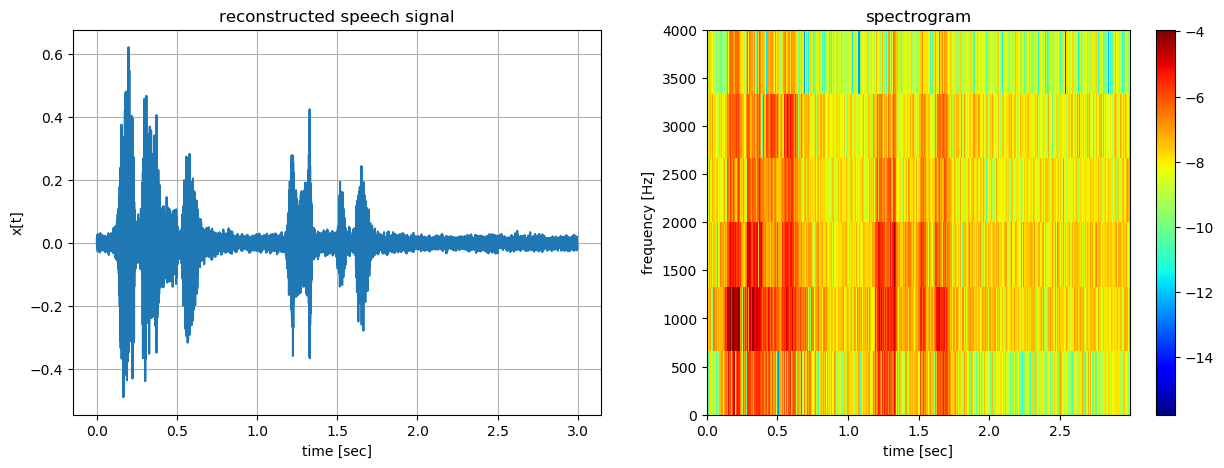

In [20]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t[1:length(Œº_x_pred1_first)], Œº_x_pred1_first)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(Œº_x_pred1_first, 2*length(freq), 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("reconstructed speech signal"), ax[2].set_title("spectrogram")

#plt.plot(Œº_x_pred1_first)
audioplayers(x_time1, x_time2, x_tot, Œº_x_pred1_first, fs=fs_desired)
;

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQBGmbQ8fipHPduSKj2LnQQ9f8icPAh4ETy2sAu8jBPOvBMsCr3VU/G8OWa0vF/NHbxh1zu79oG+O9VYmTsgK+g7rZBtPBCmejyUuII8bnWHPCwYjTzxfoI8dkDZO3msObw7Aee8Yc4FvaN0Gr3fdf68o+ePvHdxlLsfipA8w+YqPYEabT3DYYQ9fx5xPc3PRj1tBSg9x5wNPV9t3Dx8pMg8cDeZPM+UqDv3YCm8XHSKvFcleLwyCWu8KjkIvDoVFDt8h3Q5IPqhOzkMszzvExU9gI02PVIbIz1vsd48at6nO5hQrbxJySK9IzVavSOLiL0eHpO90gR3vYnNNr2XSMu8Yn+Ju25iRjy/scA8bUaJPJ8u/TsmzL+7IH5vvKUr+rxxzSG9nrMYvdHs3rwFdIS8rFAyvGFTdbxL3y68UcZhutQcZzvA/W48W9CIPK62tjw/ja88Lmx5PDwJcjsN1kq8To4NvalBQr3Jdk698i88vRnh/rxZ1kW8fGvlO5wfyDw9QCI9O0A/PcMNMD118ew8eGsfPDGViLo1YS28CNi8vMJEH73MCVO9eq9tvSJTab0zEEi9J17cvAIvO7xMewA69rYFPMNogTxX5aU8SeKfPHd7lTy377g8btrsPAHc/jxu9sU8vgz4O8BhK7w8ury8lB/JvG2AsLwCwpO8B8cevK2GaDulRqI8rswfPfpgST1iYUU97UkdPYjrpzxbVoC7v3vSvBj9IL0Xyj69PQRTvT9OXr14u2u9WDFsvXdCWb3kLjK9tHfevOsYiLxDcdK7GZeDu0DmJDt1j7Q7CZBjO+QxAbvjvA+87tbJvF3M9ry8cw+9fzUQvUmIpbx0V9g72PkUPfHAWT1Hnno94Y1vPZsCOz3NbwY9tna2PEnbBjwkeCq8/o8CvazBOb3+pDm9zJAavebK7LwoKI28IA0tvI7aIbz42pi7JIDNO9HsizwQzbc8oaPGPGGd3jy4Y8k8znoYPPs/aLyPoRe94EtIvVR8Zr2QlGC9vYMSvaSVG7zGZYM87SkOPY5ePj1ozW49F5CBPY8SWD1aTjM92Lr9PKGnjjzt7l08XYlRPJ5tYTySjj08VXGiO79unLoZ2p66JWybO4/XgDywTak8wbSvPGMyyDyI0Oo8kwQdPbeXOD3+7xY9LfAbPPCQi7xjT/q8niUuvfdaV70jA3q9DOdcvV3BNb1GlNi89YbWu4wWXDxV7bk8/z+OPEyWOzyeRIQ75fzIu/AanLwu9xG9lYo7vXPeRL3/+Cm9p1PWvIqzC7wXHo47xDU7PNfkHDwYl+I7wdT0Oyvg3jsVuFY7b/XTukhW/rsod7e8ajQhvZqKUL2iImu9FvRtvW/hUL1arRi9p7iCvCx2wDtkILw8Okw8PUEHdD0pM109zeMMPc7vZDy5fEg706iVu2QbWLxvdKW8aoa1vF7Zwrwf4Oy8w60BvRP2z7z1s268yUOxux8/DTzcn4Y8bsevPB960DxuUNo8tHzyPNoV4TxbKnM89nsGPIQvxztC94G7WQ7zu+iO47t8JAy7aeAnPMxhsTx85wo9wQAlPfFWGz2/qR09t8kaPb3P/Dxj8ZQ82OE1u+sTkbxTLce8GWb3vLovBb1otSO9TI81vTANN71kWi69WDgNvRgs87yZ5sS85B1cvItUO7sva4o7Ss2VuTOvg7z0NQa9utlDvZ3hbb0zPWq9Dd9Bvb/IBL0hJn+8vaO0O/yhwjxdsio9vA0+PZ8lJD1uwNI8JZ0hPJsY/DqulDq8jurzvJU4Fb0iJwW9gWnwvJALtrypkJC8+3gJvHkamDiv17U7O4QhPEAxkjyqqcI8nYDZPJHB2DxQHdE8EfWjPKTlCzxtODK82vQLvZQ7Ur24H3G9M/tlvZqvM70qHNq8ae8HvFhNKTwDMgA956QiPTjrDD0oW7E8V3IIPEwBtbqWCA28B7MvvNUXs7vK0n06uayUOh9TSzs/pvg6U1YCu/J3gjq/Akc7/EQRPD9uTTy9S8Y8CHQePVjuVj2twl49ejcUPZlPNTyg9XS8Bn4cvW/NXr3xkoK9kYtqvQIHJL3lgq+8ILZaudWXnjzrFP08XcEEPYBU4DwSrpg8jwnuO9/SpLvXW0W8bT2CvLPoTLyRrES8zeEqvAp7mLqMVo87jnROPCWFqzypuKs8JQiTPNFlsjzDP708nLelPEwSkTwiUg08bny3u3TWmLxNIe28I/gLvfIZG70zNRi9Nm3ZvKwOlruxTtA8oOg+PXcCZD3arUo9gCsAPa9roDw5zoM8IMRIPOFPYjsKHse7sGlsvP5doLyaBqW8WIKMvFP/k7yW5ai8g4SCvKvAGrw1qQw6qy9vPLmP4Dz3zBI9z8oYPfNa4DxoyYY8EbAKu/8DiLwzb+W8NTodvZDmJL1Yqiy9rR4Mve19obwK+du7WHcQPN4ciTwAEXc8/eFnPNchIjw5s6Q7OjMGu28KWLyTrOG8XSsPvcRiKL0b6SW97pYgvQLsI7070RC9fTYGvb4Lx7z9W1a8QDzju5MRRjp3eSI7eg7BuUEB+Lu6aLS8+VMAvTeqPr39SXO9OGGAvY0YV72Ry+C8B+uiORCmqzwgSQU92dENPZ8qDj1M5+Q8DMSIPE1NpDqWiD28unWQvN1Ocbwalsq6jvkrOx48QzuuZ2474inKOkLc5zs+Cyo8ImYGPHdn+js10+I62oAXO1g5LTtQ2Zw6mUHpu3SsobxNJwW9bstIvYwMdL0HiZC9avOUvU6Gj71MamS9SJ4BvTS/lbsaHaU8qczzPJfxCj2XajA9RrNoPW1rkD0f4aE9qPe2Pfzivz1yOsk91EvTPWpbyT3VH7M9L36SPfh6aD3GQys9eeTcPB9+KTw7rOc6Bt76uvOsmruMQxC8hqatvD6+LL3/X2u94TOLvfvunr2P+qu9tqG2vdvyrL1PWJC9cgRHvZ+r9Lx0oYa8Iz7yu+N3qbjfdqs7ba8nPFDojjzIH7A8XqnfPBPA+TyRdwI9ZUsGPTbeET3y+iE9AqkkPdibEj2+Mtc8y+6dPBHHUjy1VoI550Y/vB+Gu7yySSe9ONJ3veYOoL37Gru9AhW9vfqMt70zmKO9xjtrvZn23Ly2bLc7yIX9PB6WQD0gCnc9EUOEPWTkfD0KZGQ9zqRHPaPIIz1mPw096pEePT+RFD3R3PI8+j3CPCU1gjwx0mE81UEZPMlhQrtRbHu8a5LgvNB4Br3zDRm99v8HvfVfCL0NMhq96HQhvVA4J72bmyS9FQsmveCsFL2U76+8W7MPO+gH/TwwAFk9DgyHPXYSjj1oE4c94hFdPbGWQj243Uo9NLpEPVAGNT1m9Aw9hl/YPOgLoDweeF48c6T3Ooogm7wmNgi9WF09vUL3aL2zy4K9lF2avQfdoL2+A569k/CgvQUes7077NG9eMntvaEuAb5Lcv298UvrveALyL0b0Za9VTovvWV5H7wC+lk8BfPWPOaDCD0DWAk9U0AFPTxT8zxiwb48s16WPPYNWDyWSVU8aCWbPOSz1Tz8/d08rKPqPPEfBj3Nng89CNv2PN8JnTw1mgg8QHgaO5uyyzqtDHU7T12oO15AoTn4eIO7VAwovNQNqLzI9+283ij4vE4Nq7zoBNm7WUPkO7jlqzwYGvc8eXAVPQ06DD1+gck8bS9nPMPmQzw3LHE8v7NdPD32Bjz/G+U6W/oAvEITcLxm+bC8ppq8vPfr5rx3gwa9O5DyvOuuzbwMoLC8BaJGvPgLQruumDk8d7/1PBO9Mz3Tolo9WY5ePVfiVz1C9Gk9qwiCPZTQmj3DP7k9T+bFPWmXxj1Xq7g9VMqfPUUmfj23azQ9L4vHPEkIQDsknM+8QGJDvZmjkr2zZci9L2n8vWseDb6/m

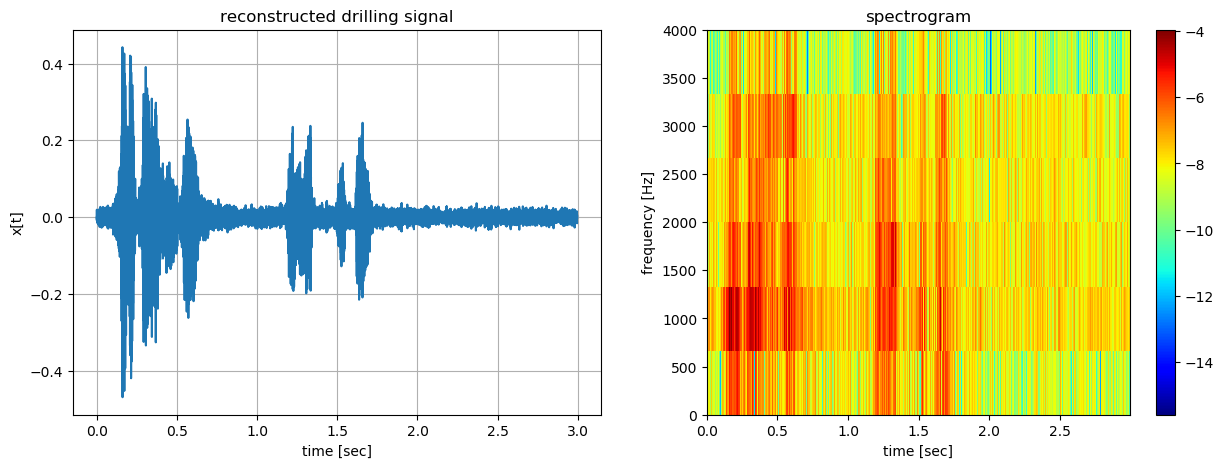

In [21]:
# create figure with subplots
_, ax = plt.subplots(ncols=2, figsize=(15,5))

# plot speech signal as a function of time
ax[1].plot(t[1:length(Œº_x_pred2_first)], Œº_x_pred2_first)

# plot spectrogram of speech signal
plot_spectrogram(spectrogram(Œº_x_pred2_first, 2*length(freq), 0, fs=fs_desired), fs_desired, ax=ax[2], colorbar=true)

# visual modifications
ax[1].grid(), ax[1].set_ylabel("x[t]"), ax[1].set_xlabel("time [sec]"), ax[1].set_title("reconstructed drilling signal"), ax[2].set_title("spectrogram")

#plt.plot(Œº_x_pred1_first)
audioplayers(x_time1, x_time2, x_tot, Œº_x_pred2_first, fs=fs_desired)
;

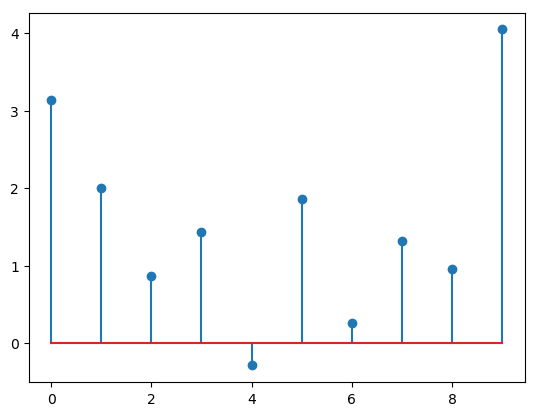

(35952.001000000004, 38892.05442632935, (PyObject <matplotlib.lines.Line2D object at 0x0000000002477B70>, PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0000000002477EF0>, PyObject <matplotlib.lines.Line2D object at 0x00000000024820F0>, PyObject <matplotlib.lines.Line2D object at 0x0000000002482400>, PyObject <matplotlib.lines.Line2D object at 0x0000000002482710>, PyObject <matplotlib.lines.Line2D object at 0x0000000002482A20>, PyObject <matplotlib.lines.Line2D object at 0x0000000002482D30>, PyObject <matplotlib.lines.Line2D object at 0x000000000248D080>, PyObject <matplotlib.lines.Line2D object at 0x000000000248D390>, PyObject <matplotlib.lines.Line2D object at 0x000000000248D6A0>, PyObject <matplotlib.lines.Line2D object at 0x000000000248D9B0>], PyObject <matplotlib.lines.Line2D object at 0x0000000002477CF8>))

In [22]:
bin = 10
params1[bin]["a_gamma"], params2[bin]["b_gamma"], plt.stem([log.(params1[bin]["a_gamma"]/params1[bin]["b_gamma"]) for bin = 1:2*length(freq)])

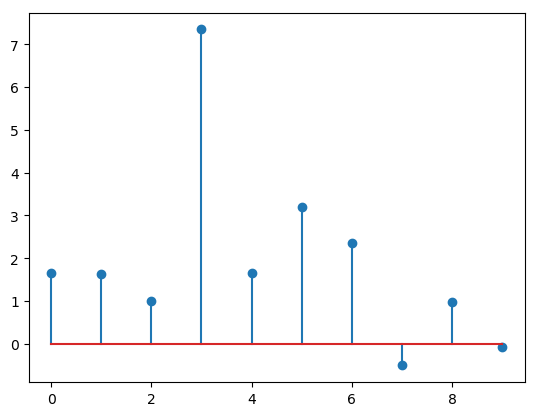

(35952.001000000004, 38892.05442632935, (PyObject <matplotlib.lines.Line2D object at 0x0000000002627198>, PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x00000000026274E0>, PyObject <matplotlib.lines.Line2D object at 0x00000000026276A0>, PyObject <matplotlib.lines.Line2D object at 0x00000000026279B0>, PyObject <matplotlib.lines.Line2D object at 0x0000000002627CC0>, PyObject <matplotlib.lines.Line2D object at 0x0000000002627FD0>, PyObject <matplotlib.lines.Line2D object at 0x0000000002631320>, PyObject <matplotlib.lines.Line2D object at 0x0000000002631630>, PyObject <matplotlib.lines.Line2D object at 0x0000000002631940>, PyObject <matplotlib.lines.Line2D object at 0x0000000002631C50>, PyObject <matplotlib.lines.Line2D object at 0x0000000002631F60>], PyObject <matplotlib.lines.Line2D object at 0x00000000026272B0>))

In [23]:
params1[bin]["a_gamma"], params2[bin]["b_gamma"], plt.stem([log.(params2[bin]["a_gamma"]/params2[bin]["b_gamma"]) for bin = 1:2*length(freq)])